In [18]:
# Import all the necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the CIFAR-10 dataset and divide it into training and testing sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Check the shape of the datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


# 1. Data Preprocessing

In [3]:
# Normalize the images scaling pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [4]:
# Convert class labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

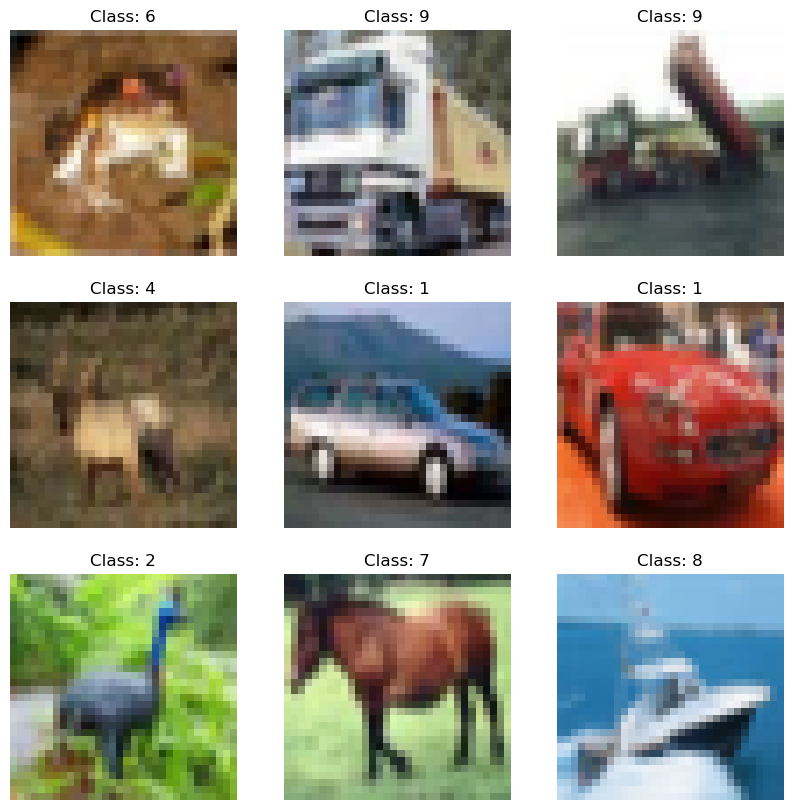

In [5]:
# Display a few random images from the training set
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {y_train[i].argmax()}")
    plt.axis('off')
plt.show()

# 2. Model Architecture

In [6]:
# Build a Convolutional Neural Network (CNN) suitable for image classification.

# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Build the CNN with convolutional blocks and poolings (flatten, dropout and dense at the end to fully connect layers)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(), # Adding batch normalization after each convolutional block can help stabilize and faster the training.
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),  # Add dropout to reduce overfitting

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),
    
        layers.Flatten(),
        layers.Dense(256, activation="relu"), # Add a fully connected layer before the output
        layers.Dropout(0.5), # Increase dropout for the fully connected layer
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,441,066 (5.50 MB)

 Trainable params: 1,439,146 (5.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

# 3. Model Training

In [7]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0003), metrics=["accuracy"])

# Train the model
history_cnn = model.fit(X_train[:8000], y_train[:8000], batch_size=32, epochs=60, validation_split=0.1)

Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.1634 - loss: 3.1818 - val_accuracy: 0.0913 - val_loss: 3.4351
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.2555 - loss: 2.0175 - val_accuracy: 0.1412 - val_loss: 3.1301
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.3142 - loss: 1.8409 - val_accuracy: 0.3313 - val_loss: 1.8434
Epoch 4/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.3560 - loss: 1.7441 - val_accuracy: 0.4025 - val_loss: 1.6365
Epoch 5/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.3938 - loss: 1.6447 - val_accuracy: 0.4025 - val_loss: 1.5981
Epoch 6/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.4255 - loss: 1.5691 - val_accuracy: 0.4363 - val_loss: 1.5140
Epoch 7/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.4540 - loss: 1.5071 - val_accuracy: 0.4688 - val_loss: 1.4918
Epoch 8/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.4607 - loss: 1.44

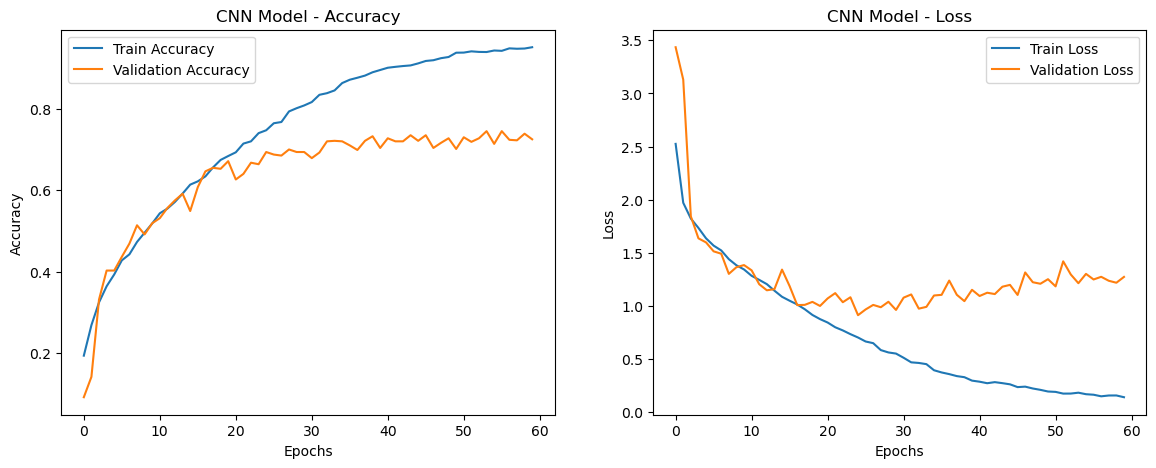

In [8]:
# Function to plot the training and validation accuracy and loss
def plot_accuracy_and_loss(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot accuracy and loss for the Custom CNN model
plot_accuracy_and_loss(history_cnn, 'CNN Model')

# 4. Model Evaluation

In [9]:
# List of CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
# Compute and report metrics 
score = model.evaluate(X_test, y_test, verbose=3)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.3723511695861816
Test accuracy: 0.7222999930381775


In [11]:
# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


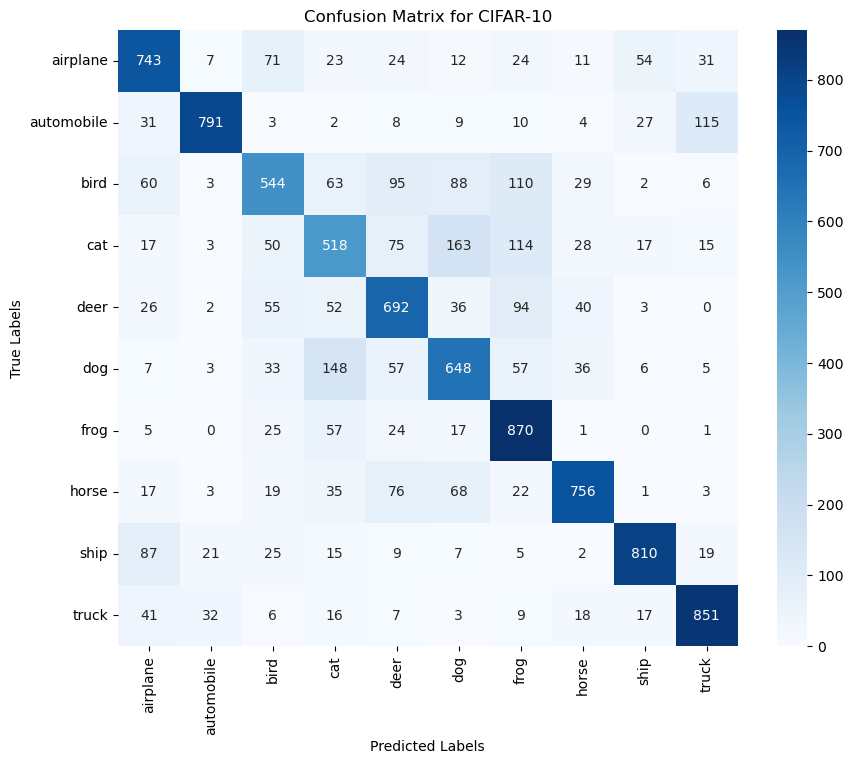

In [12]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix to understand model performance across different classes.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()

In [13]:
# Save Model as pickle file
import pickle
with open('CNN_Charlie_Dani.pkl', 'wb') as f:
    pickle.dump(model, f)

# 5. Transfer Learning (with VGG16)

In [19]:
# Load VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# Add GlobalAveragePooling2D layer to flatten the output of VGG16
avg = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer for classification
output = layers.Dense(num_classes, activation='softmax')(avg)

In [21]:
# Add new fully connected layers on top of VGG16 for CIFAR-10 (10 classes)
combined_model = models.Model(inputs=base_model.input, outputs=output)

# Summary of the model
combined_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the CIFAR-10 dataset
history_vgg16 = combined_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 128s 90ms/step - accuracy: 0.2905 - loss: 2.0194 - val_accuracy: 0.4898 - val_loss: 1.5449
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 138s 98ms/step - accuracy: 0.4860 - loss: 1.5316 - val_accuracy: 0.5274 - val_loss: 1.4182
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 141s 100ms/step - accuracy: 0.5189 - loss: 1.4234 - val_accuracy: 0.5426 - val_loss: 1.3590
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 128s 91ms/step - accuracy: 0.5369 - loss: 1.3649 - val_accuracy: 0.5546 - val_loss: 1.3213
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 129s 91ms/step - accuracy: 0.5449 - loss: 1.3316 - val_accuracy: 0.5526 - val_loss: 1.2946
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 124s 88ms/step - accuracy: 0.5636 - loss: 1.2939 - val_accuracy: 0.5624 - val_loss: 1.2787
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 126s 90ms/step - accuracy: 0.5690 - loss: 1.2731 - val_accuracy: 0.5670 - val_loss: 1.2601
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 128s 91ms/step - accuracy:

In [23]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile and fine-tune the model
combined_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_vgg16 = combined_model.fit(X_train[:8000], y_train[:8000], epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 88s 190ms/step - accuracy: 0.5113 - loss: 1.4282 - val_accuracy: 0.6062 - val_loss: 1.0947
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 87s 193ms/step - accuracy: 0.6924 - loss: 0.8597 - val_accuracy: 0.6175 - val_loss: 1.0790
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 89s 197ms/step - accuracy: 0.7761 - loss: 0.6299 - val_accuracy: 0.6600 - val_loss: 1.0444
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - accuracy: 0.8586 - loss: 0.4054 - val_accuracy: 0.6538 - val_loss: 1.0990
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 78s 169ms/step - accuracy: 0.8999 - loss: 0.2837 - val_accuracy: 0.6325 - val_loss: 1.2970
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.9345 - loss: 0.2116 - val_accuracy: 0.6725 - val_loss: 1.2169
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - accuracy: 0.9484 - loss: 0.1634 - val_accuracy: 0.6400 - val_loss: 1.3700
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 77s 170ms/step - accuracy: 0.9553 - loss: 0

In [24]:
# Evaluate on the test data
score = combined_model.evaluate(X_test, y_test, verbose=2)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

313/313 - 38s - 122ms/step - accuracy: 0.6526 - loss: 1.7165
Test loss: 1.7165441513061523
Test accuracy: 0.6525999903678894


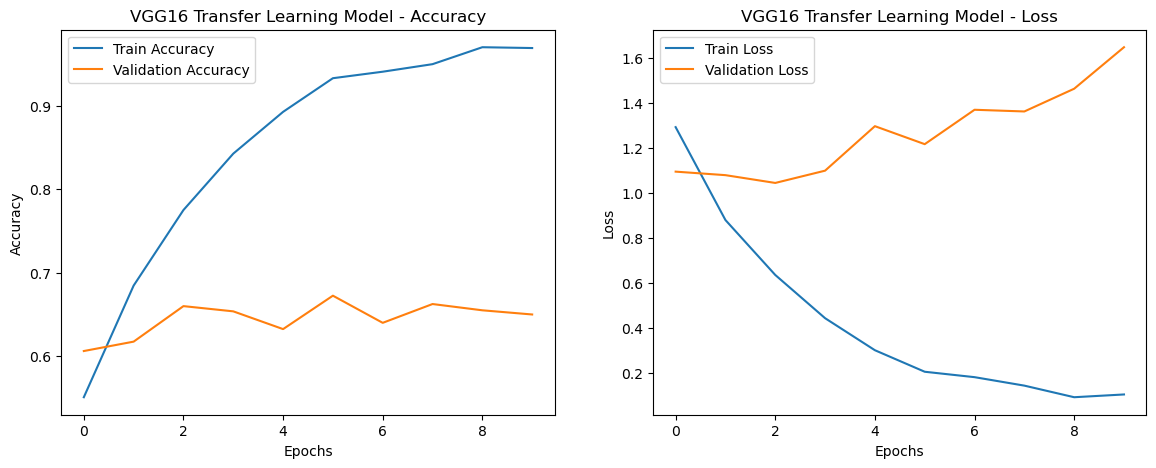

In [25]:
# Plot accuracy and loss for the Custom CNN model
plot_accuracy_and_loss(history_vgg16, 'VGG16 Transfer Learning Model')

In [26]:
# Get predictions for the test set
y_pred = combined_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step


In [27]:
# Classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.69      0.70      1000
  automobile       0.83      0.68      0.75      1000
        bird       0.51      0.67      0.58      1000
         cat       0.49      0.42      0.45      1000
        deer       0.52      0.71      0.60      1000
         dog       0.61      0.52      0.56      1000
        frog       0.69      0.69      0.69      1000
       horse       0.80      0.63      0.71      1000
        ship       0.73      0.80      0.76      1000
       truck       0.75      0.73      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.65     10000
weighted avg       0.67      0.65      0.65     10000



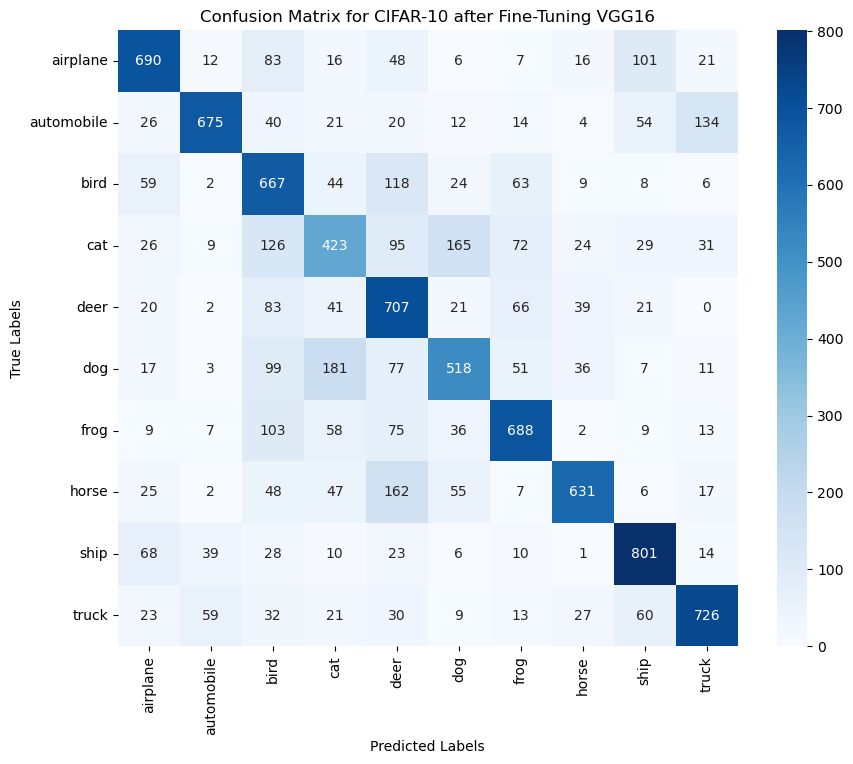

In [28]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10 after Fine-Tuning VGG16')
plt.show()

In [29]:
# Save Model as pickle file
import pickle
with open('VGG16_Charlie_Dani.pkl', 'wb') as f:
    pickle.dump(combined_model, f)